# Exploration of the LIDC-IDRI analysis results

# About

The purpose of this notebook is to provide a demonstration of how standard DICOM objects containing annotations and evaluations of the nodules for the TCIA [LIDC-IDRI](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI) collection hosted on the Imaging Data Commons (IDC) can be examined using various standard tools and components provided by IDC and Google Cloud platform.

Detailed description of the dataset is available in the open access article below.

> Fedorov, A., Hancock, M., Clunie, D., Brochhausen, M., Bona, J., Kirby, J., Freymann, J., Pieper, S., J W L Aerts, H., Kikinis, R. & Prior, F. DICOM re-encoding of volumetrically annotated Lung Imaging Database Consortium (LIDC) nodules. Med. Phys. (2020). https://doi.org/10.1002/mp.14445

**The latest version of the notebook is in this repository: https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/LIDC_exploration.ipynb**

# Prerequisites

This notebook assumes that you: 
* have internet access
* have a Google identity
* configured a project under Google Cloud Platform the following locally on your computer (**TODO: you can see how to complete this step in this tutorial**)
* replace all occurrences of `##MY_PROJECT_ID##` with the ID of the GCP project you have confugured under your account

Let's authenticate to be able to perform any queries, and import the packages we will be using to work with the data.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import pandas as pd
import os, json
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook 

# TODO: update the viewer URL with the production instance
def get_idc_viewer_url(studyUID):
  return "https://testing-viewer.canceridc.dev/viewer/"+studyUID

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data exploration

To explore the data, we will query BigQuery tables maintained by IDC that contain all of the DICOM metadata for hosted content.

**TODO: You can learn about the organization of the IDC BQ tables here**



### CT Images

IDC BQ tables contain one row per DICOM instance. Let's first subset all rows that correspond to the instances of CT modality from the `lidc_idri` collection, and get count the number of CT series for each patient.

Note the syntax of the `%%bigquery` command: the last argument specifies the name of the pandas data frame that will contain the result of the query.

**NOTE**: you will need to replace the "PROJECT_ID" placeholdler with the ID of your GCP project!


In [ ]:
%%bigquery --project=##MY_PROJECT_ID## ct_series_counts

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    PatientID
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT
  PatientID,
  COUNT(PatientID) AS ct_series_count
FROM
  all_lidc_ct_series
GROUP BY
  PatientID
ORDER BY
  ct_series_count DESC

How many subjects do we have? Which subjects have more than one CT series?


In [ ]:
num_subjects = ct_series_counts["PatientID"].shape[0]
print(f"Total number of subjects: {num_subjects}")

print("\nSubjects with more than one CT series:")
ct_series_counts[ct_series_counts["ct_series_count"]>1]

Total number of subjects: 1010

Subjects with more than one CT series:


,PatientID,ct_series_count
0,LIDC-IDRI-0315,2
1,LIDC-IDRI-0365,2
2,LIDC-IDRI-0442,2
3,LIDC-IDRI-0355,2
4,LIDC-IDRI-0151,2
5,LIDC-IDRI-0484,2
6,LIDC-IDRI-0332,2
7,LIDC-IDRI-0132,2


We can use BQ to examine various aspects of the dataset, for example those related to the heterogeneity of acquisition in the data.

In [ ]:
%%bigquery --project=##MY_PROJECT_ID## slice_thickness

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    PatientID,
    SliceThickness
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
  SELECT SliceThickness FROM
    all_lidc_ct_series

count    1018.000000
mean        1.918713
std         0.728916
min         0.600000
25%         1.250000
50%         2.000000
75%         2.500000
max         5.000000
Name: SliceThickness, dtype: float64

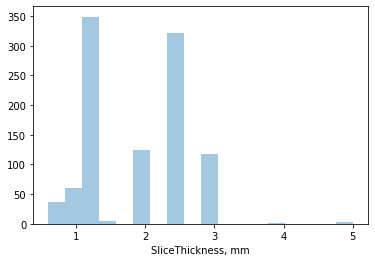

In [ ]:
%matplotlib inline
ax=sb.distplot(slice_thickness["SliceThickness"].astype(float),kde=False)
ax.set(xlabel="SliceThickness, mm")
slice_thickness["SliceThickness"].astype(float).describe()

In [ ]:
%%bigquery --project=##MY_PROJECT_ID## pixel_spacing

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    PatientID,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelSpacingStr
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
  SELECT pixelSpacingStr FROM
    all_lidc_ct_series

count    1018.000000
mean        0.687689
std         0.084851
min         0.460938
25%         0.625000
50%         0.698609
75%         0.742188
max         0.976562
Name: 0, dtype: float64

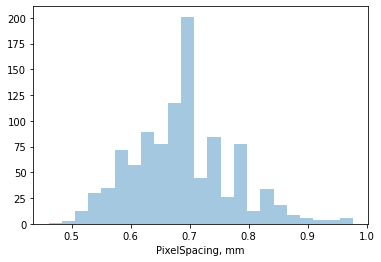

In [ ]:
xSpacing = pixel_spacing["pixelSpacingStr"].str.split('/',n=1,expand=True)[0].astype(float)
ax=sb.distplot(xSpacing, kde=False)
ax.set(xlabel="PixelSpacing, mm")
xSpacing.describe()

### Segmentations

LIDC collection includes segmentations stored as DICOM Segmentation objects. **TODO: You can read more about what those are here.**

Since most of the metadata related to segmentations is stored in DICOM sequences, and it is a bit cumbersome to query metadata located in sequences (which are stored in BigQuery RECORD data type), we will use the data views maintained by IDC that flatten some of that data to simplify access. 

**TODO: you can read more about the data views that are maintained by IDC here**

You can read in detail about the data organization in [this paper](https://doi.org/10.1002/mp.14445), but in a nutshell, a subset of CT series included in the LIDC collection contains lung nodules, which were annotated volumetrically by a group of readers. 

First, let's look at the overall summary of the annotations - number of annotations per nodule, and number of nodules per subject.

In the query below, we take segmentation-specific attributes from the `segmentations` view, and join it with the selected attributes from the table that contains all of the DICOM metadata and collection-level metadata.

One such collection metadata is the `Source_DOI`, which is the Digital Object Identifier (DOI) corresponding to the TCIA collection with the LIDC annotations stored in DICOM format. Since each primary collection can have multiple groups of analysis results associated with it, we use the DOI to subset just a single analysis results collections identified by DOI https://doi.org/10.7937/TCIA.2018.h7umfurq.

In [ ]:
%%bigquery --project=##MY_PROJECT_ID## segmentations

with lidc_segmentations as (
SELECT
  collection_id, 
  all_attributes.PatientID,
  all_attributes.SeriesDescription,
  TrackingID,
  TrackingUID,
  all_attributes.StudyInstanceUID,
  all_attributes.SOPInstanceUID,
  all_attributes.Source_DOI
FROM
  `canceridc-data.idc_views.segmentations` AS seg_attributes
JOIN
  `canceridc-data.idc_views.dicom_all` AS all_attributes
ON
  seg_attributes.SOPInstanceUID = all_attributes.SOPInstanceUID)
select * from lidc_segmentations
where Source_DOI = "10.7937/TCIA.2018.h7umfurq"
  

In the below, "annotation" corresponds to a segmentation of a nodule, with multiple segmentation potentially available for a given nodule. `TrackingUID` is a unique nodule identifier assigned by the dataset creators (details in the paper!) that can be used to associate individual annotation with a given nodule.

Total annotations: 6859
Total nodules: 2651


[Text(0.5, 0, 'annotations per nodule')]

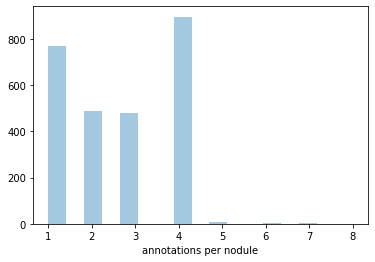

In [ ]:
print("Total annotations: "+str(segmentations.shape[0]))
print("Total nodules: "+str(segmentations.drop_duplicates(subset="TrackingUID").shape[0]))

annotationsPerNodule = segmentations["TrackingUID"].value_counts()
ax=sb.distplot(annotationsPerNodule,kde=False) #.set_title("Number of annotations per nodule")
ax.set(xlabel="annotations per nodule")

count    875.000000
mean       7.838857
std        6.805594
min        1.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       49.000000
Name: PatientID, dtype: float64

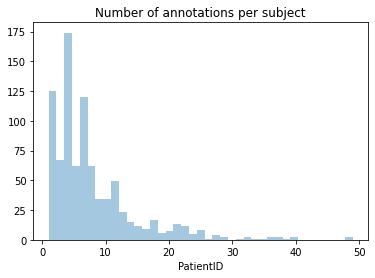

In [ ]:
# annotations per subject
annotationsPerSubject=segmentations["PatientID"].value_counts()
sb.distplot(annotationsPerSubject,kde=False).set_title("Number of annotations per subject")
annotationsPerSubject.describe()

Next we form a new table that will have a single row per nodule to look at some nodule-level statistics.

count    875.000000
mean       3.029714
std        2.680386
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       23.000000
Name: PatientID, dtype: float64

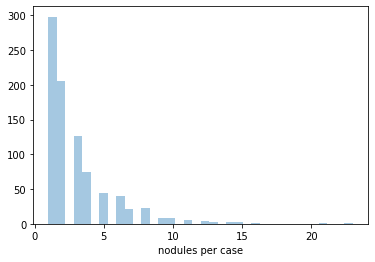

In [ ]:
# nodules per case, case being "patient"
oneAnnotationPerNodule=segmentations.drop_duplicates(subset="TrackingUID")["PatientID"].value_counts()
ax=sb.distplot(oneAnnotationPerNodule,kde=False) #.set_title("Number of nodules per patient")
ax.set(xlabel="nodules per case")
oneAnnotationPerNodule.describe()

## Visualization of interesting cases

If there is an interesting case or annotation, it is easy to visualize it using the IDC-maintained image viewer.

Let's find a case that has the largest number of nodules.

In [ ]:
# who has most nodules?
oneAnnotationPerNodule.head(3)

LIDC-IDRI-0583    23
LIDC-IDRI-0686    21
LIDC-IDRI-0855    16
Name: PatientID, dtype: int64

Now that we know `PatientID`s for those, we can get `StudyInstanceUID` - and open the corresponding study in a viewer!

In [ ]:
segmentations[segmentations["PatientID"] == "LIDC-IDRI-0583"].drop_duplicates(subset="StudyInstanceUID")["StudyInstanceUID"].values[0]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.230901123329037029807195618747'

To open the study in the viewer, just append the `StudyInstanceUID` value above (`1.3.6.1.4.1.14519.5.2.1.6279.6001.230901123329037029807195618747`) to the IDC viewer prefix:

In [ ]:
print(get_idc_viewer_url("1.3.6.1.4.1.14519.5.2.1.6279.6001.230901123329037029807195618747"))

https://testing-viewer.canceridc.dev/viewer/1.3.6.1.4.1.14519.5.2.1.6279.6001.230901123329037029807195618747


## Evaluations and measurements

Each annotation of the nodule is accompanied by its qualitative assessment performed by the reader, and quantitative measurements (volume and surface area) calculated based on the definition of the segmented region.

All of those annotations are stored in DICOM Structured Reporting instances of SR teamplate TID 1500 (**TODO: read more about it here**), with each set of measurements associated with a single segmentation and stored in a single instance of the DICOM SR object.

Similar to the segmentation objects, navigating the content of DICOM SR objects can be quite complex, and IDC provides table views that simplify access to the measurements contained in SR documents (**TODO: read more about those views here**).

Let's first get all the measurements, see what kinds of measurements are available for this collection, and how to access them.

In [ ]:
%%bigquery --project=##MY_PROJECT_ID## quantitative_measurements

with lidc_measurements as (
SELECT
  collection_id, 
  all_attributes.PatientID,
  all_attributes.SeriesDescription,
  trackingIdentifier,
  trackingUniqueIdentifier,
  Quantity.CodeMeaning as Quantity,
  "Units.CodeMeaning" as Units,
  Value,
  all_attributes.StudyInstanceUID,
  all_attributes.SOPInstanceUID,
  all_attributes.Source_DOI
FROM
  `canceridc-data.idc_views.quantitative_measurements` AS measurements_attributes
JOIN
  `canceridc-data.idc_views.dicom_all` AS all_attributes
ON
  measurements_attributes.SOPInstanceUID = all_attributes.SOPInstanceUID)
select * from lidc_measurements
where Source_DOI = "10.7937/TCIA.2018.h7umfurq"

In [ ]:
print(f"Number of quantitative measurements: {quantitative_measurements.shape[0]}")

Number of quantitative measurements: 20577


Text(0.5, 1.0, 'Annotation volume')

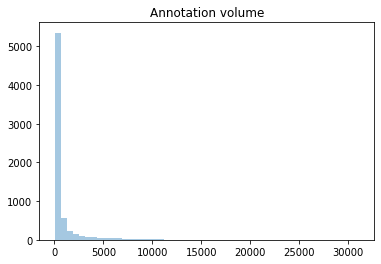

In [ ]:
volumes = quantitative_measurements[quantitative_measurements["Quantity"]=="Volume"]
sb.distplot(volumes["Value"].astype(float).values,kde=False).set_title("Annotation volume")
#volumes["Value"].astype(float).describe()

Similar to the example above, we can easily find the largest annotation, and open it in a viewer.

In [ ]:
# is that largest tumor an outlier?
largest = volumes[volumes["Value"].astype(float)==np.max(volumes["Value"].astype(float).values)]
subject = largest["PatientID"].values[0]
noduleUID = largest["trackingUniqueIdentifier"].values[0]
studyUID = pd.unique(largest["StudyInstanceUID"])[0]
#annotationLabel = segmentations[segmentations["TrackingUID"]==noduleUID]["SegmentLabel"].values[0]

print(subject)
print(largest["trackingIdentifier"].values[0])
print(get_idc_viewer_url(studyUID))
#print(annotationLabel)

LIDC-IDRI-0834
Nodule 1
https://testing-viewer.canceridc.dev/viewer/1.3.6.1.4.1.14519.5.2.1.6279.6001.224985459390356936417021464571


## Qualitative evaluations

First, retrieve qualitative measurements alongside some additional attributes from the `dicom_all` table.

In [ ]:
%%bigquery --project=##MY_PROJECT_ID## qualitative_measurements

with lidc_measurements as (
SELECT
  collection_id, 
  all_attributes.PatientID,
  all_attributes.SeriesDescription,
  trackingIdentifier,
  trackingUniqueIdentifier,
  Quantity.CodeMeaning as Quantity,
  "Units.CodeMeaning" as Units,
  Value.CodeMeaning as Value,
  all_attributes.StudyInstanceUID,
  all_attributes.SOPInstanceUID,
  all_attributes.Source_DOI
FROM
  `canceridc-data.idc_views.qualitative_measurements` AS measurements_attributes
JOIN
  `canceridc-data.idc_views.dicom_all` AS all_attributes
ON
  measurements_attributes.SOPInstanceUID = all_attributes.SOPInstanceUID)
select * from lidc_measurements
where Source_DOI = "10.7937/TCIA.2018.h7umfurq"

`Quantity` attribute can be used to figure out the type of evaluation.

In [ ]:
qualitative_measurements["Quantity"].unique()

array(['Subtlety score', 'Internal structure', 'Calcification',
       'Sphericity', 'Margin', 'Lobular Pattern', 'Spiculation',
       'Texture', 'Malignancy'], dtype=object)

Here is a VERY busy plot summarizing all of the types and values of qualitative evaluations for our cohort.

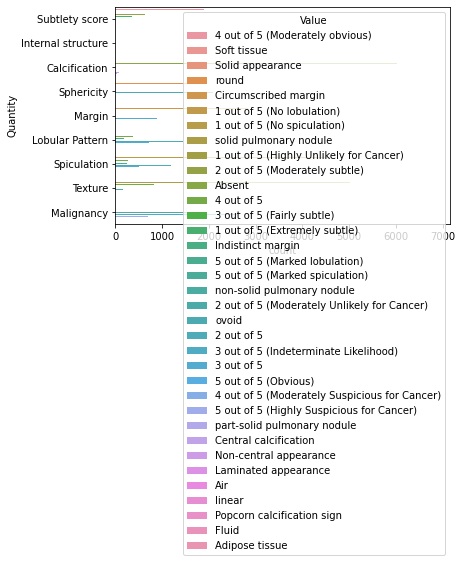

In [ ]:
%matplotlib inline

sb.countplot(y="Quantity", hue="Value", data=qualitative_measurements)

#g = sb.FacetGrid(qualitative, col="subject", col_wrap=3, height=2)
#g.map(sb.countplot, "conceptCode_CodeMeaning", "conceptValue_CodeMeaning", color=".3");

#g = sb.FacetGrid(qualitative, col="conceptCode_CodeMeaning", col_wrap=3)
#g.map(sb.countplot, "conceptValue_CodeMeaning", color=".3", orient="v")
#plt.figure(figsize=(10, 30))
#sb.countplot(y="conceptCode_CodeMeaning", hue="conceptValue_CodeMeaning", data=qualitativeWithContext)


In [ ]:

qualitative_measurements[qualitative_measurements["Quantity"]=="Internal structure"]["Value"].value_counts()


Soft tissue       6819
Air                 27
Fluid               11
Adipose tissue       1
Name: Value, dtype: int64